In [1]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import helper_functions as hf
import astropy.table as astab
import astropy
from astropy.table import vstack
import pandas as pd

running on macOS


running on macOS
1741 1741
TargetPixelFileCollection of 2 objects:
    0: TessTargetPixelFile(TICID: TIC 20215452)
    1: TessTargetPixelFile(TICID: TIC 20215452)


<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

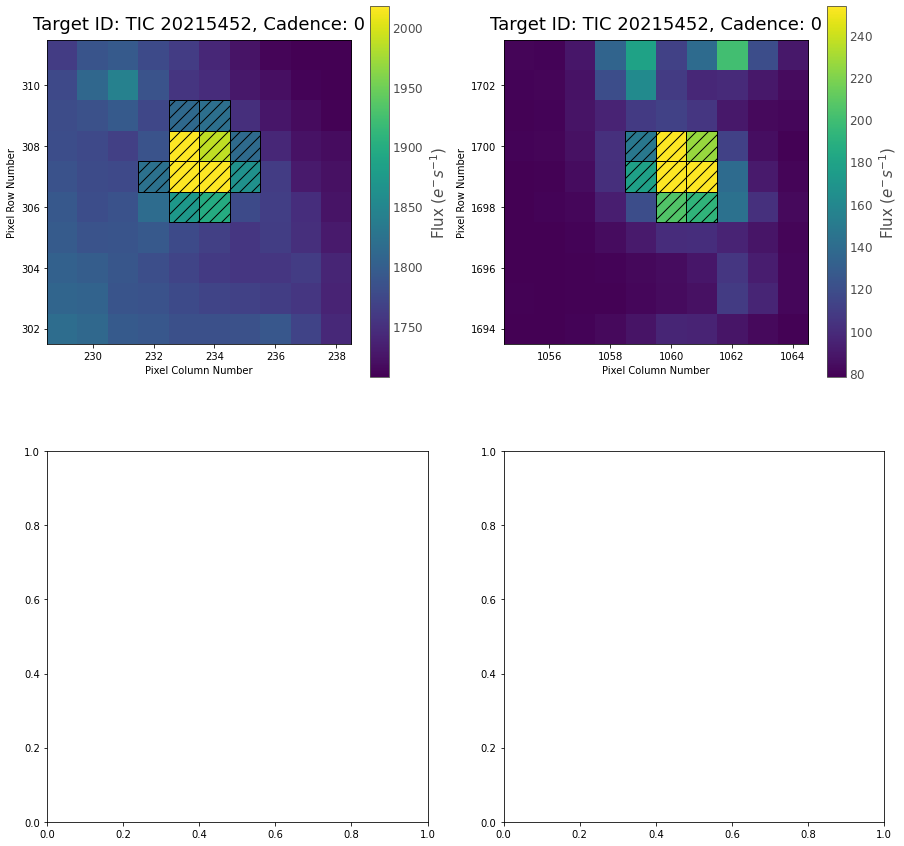

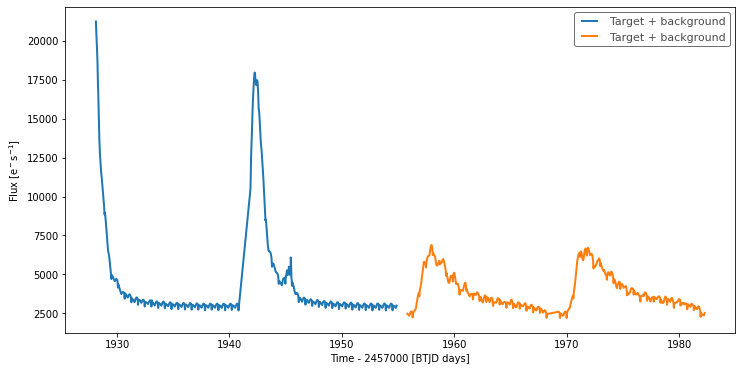

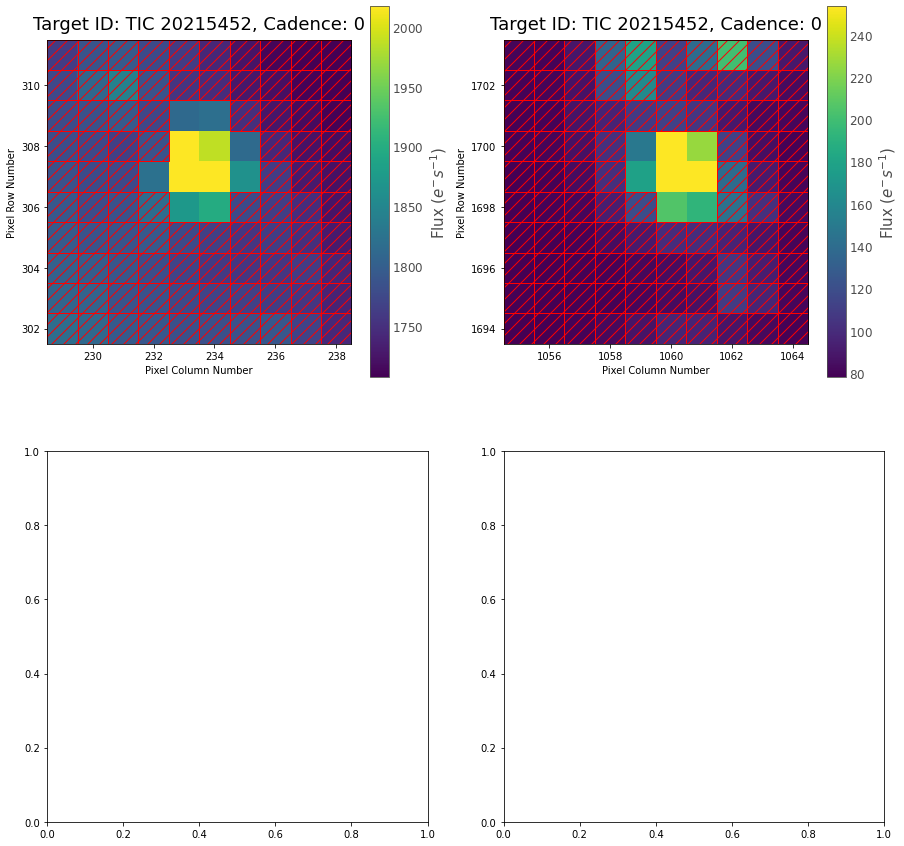

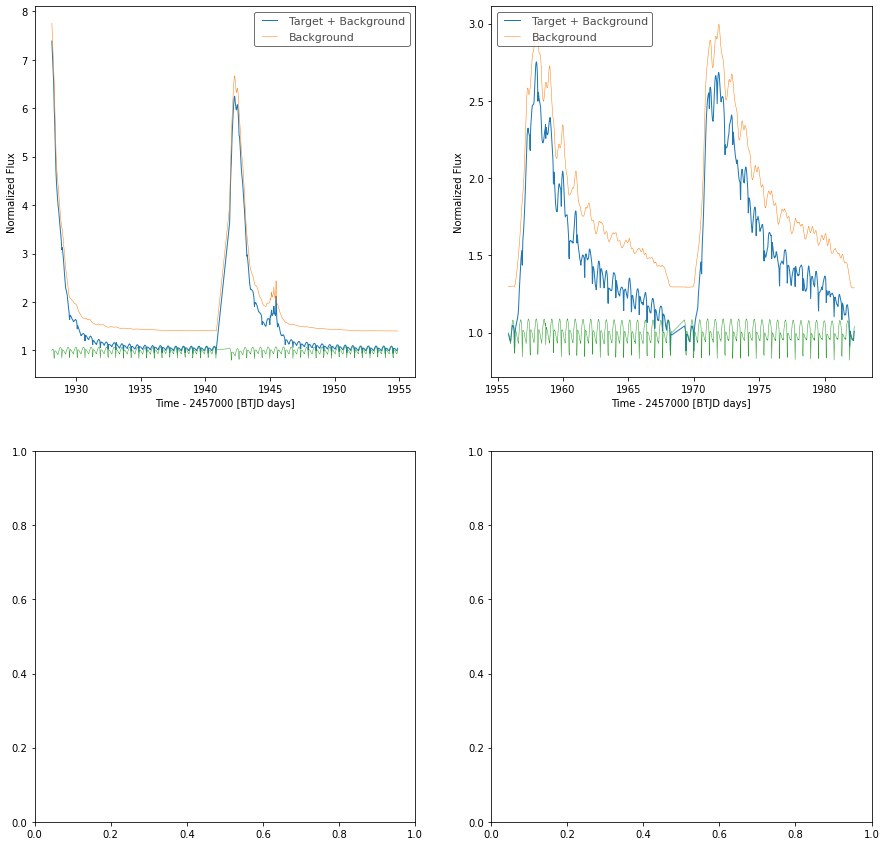

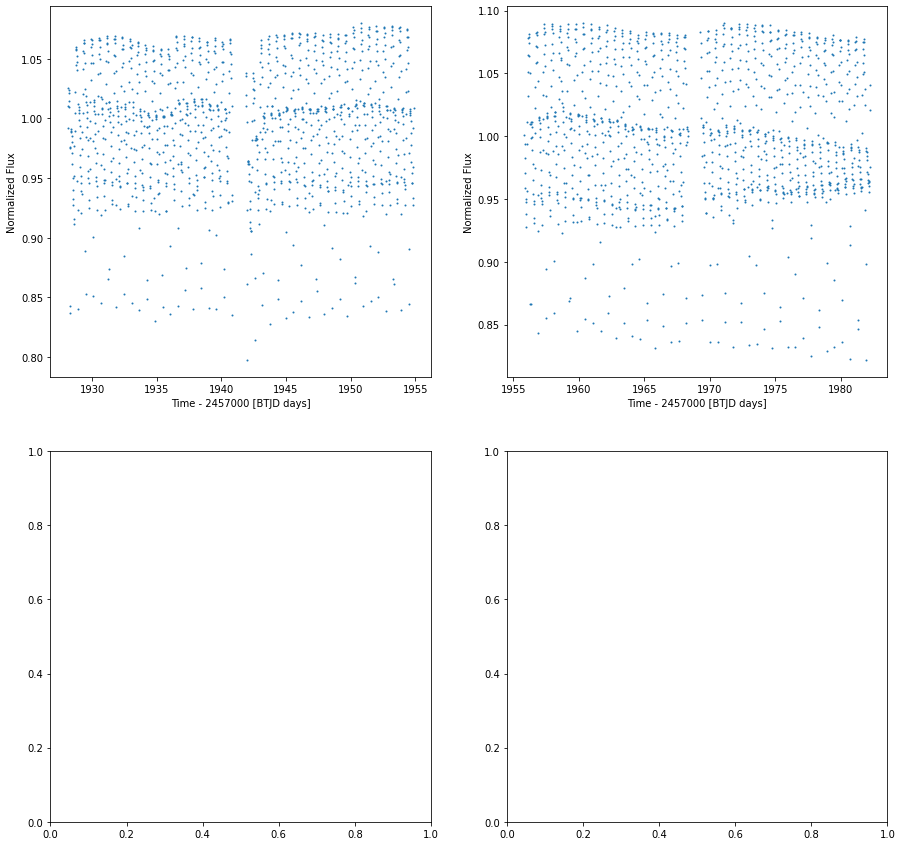

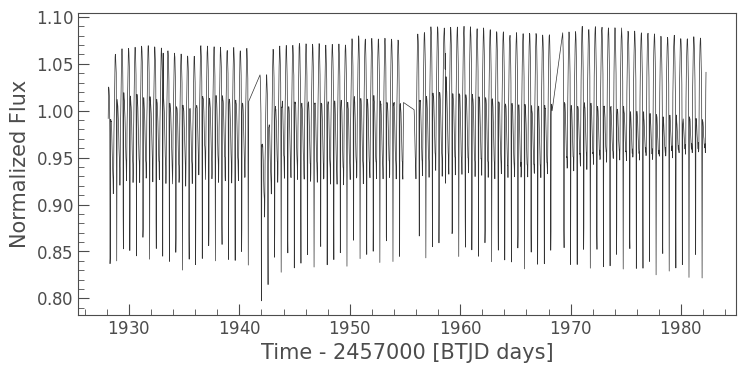

In [4]:
indx = 333
dd = hf.load_system_specific_directory()
hq_jk_allstar_tess_edr3 = astab.Table.read(dd+'dr17_joker/unimodal_joker_sample_joined_w_tess_edr3_REDUX.fits', format='fits')
hq_jk_allstar_tess_edr3['ID'][indx]

print(len(hq_jk_allstar_tess_edr3),len(hq_jk_allstar_tess_edr3['MAP_P'] <= 10))

ebcat = pd.read_csv("/Users/kjaehnig/Downloads/mast_data_export.csv")

# TIC_TARGET = f'TIC {hq_jk_allstar_tess_edr3[indx]["ID"]}'
TIC_TARGET = "TIC 20215452"
tpfc = lk.search_tesscut(TIC_TARGET).download_all(cutout_size=10)
# res = hf.load_precompiled_pymc3_model_data(DD=dd,TIC_TARGET=TIC_TARGET)
# res.keys()
print(tpfc)

ap_lim = 5
bg_lim = 5

if len(tpfc) > 1:
    tpf = tpfc
    
    target_mask = [tpi_i.create_threshold_mask(threshold=ap_lim, reference_pixel='center') for tpi_i in tpf]
    n_target_pixels = [tm_i.sum() for tm_i in target_mask]
    n_target_pixels
    
    fig,axes = plt.subplots(figsize=(15,15), ncols=int(np.ceil(np.sqrt(len(target_mask)))), nrows=int(np.ceil(np.sqrt(len(target_mask)))))
    [tpf[i].plot(aperture_mask=target_mask[i], mask_color='k',ax=axes.flatten()[i]) for i in range(len(target_mask))] 
    
    fig,axes = plt.subplots(figsize=(12,6))
    target_lcs = [tpf[ii].to_lightcurve(aperture_mask=target_mask[ii]) for ii in range(len(target_mask))]
    [target_lcs[ii].plot(label='Target + background',ax=axes, lw=2) for ii in range(len(target_mask))]
    
    background_masks = [~tpf[ii].create_threshold_mask(threshold=bg_lim, reference_pixel='center') for ii in range(len(target_mask))]
    fig,axes = plt.subplots(figsize=(15,15), ncols=int(np.ceil(np.sqrt(len(target_mask)))), nrows=int(np.ceil(np.sqrt(len(target_mask)))))
    [tpf[ii].plot(aperture_mask=background_masks[ii], mask_color='r', ax=axes.flatten()[ii]) for ii in range(len(target_mask))];
    n_background_pixels = [background_masks[ii].sum() for ii in range(len(target_mask))]
    n_background_pixels
    
    background_lcs_per_pixel = [tpf[ii].to_lightcurve(aperture_mask=background_masks[ii]) / n_background_pixels[ii] for ii in range(len(tpf))]
    background_estimate_lcs = [background_lcs_per_pixel[ii] * n_target_pixels[ii] for ii in range(len(tpf))]
    common_normalizations = [np.nanpercentile(target_lcs[ii].flux, 5) for ii in range(len(tpf))]

    fig,axes = plt.subplots(figsize=(15,15), ncols=int(np.ceil(np.sqrt(len(target_mask)))), nrows=int(np.ceil(np.sqrt(len(target_mask)))))
    [(target_lcs[ii] / common_normalizations[ii]).plot(ax=axes.flatten()[ii], normalize=False, label='Target + Background', lw=1) for ii in range(len(tpf))];
    [(background_estimate_lcs[ii] / common_normalizations[ii] +1).plot(ax=axes.flatten()[ii], normalize=False, label='Background',
                                                            ylabel='Normalized, shifted flux') for ii in range(len(tpf))];
    corrected_lcs = [target_lcs[ii] - background_estimate_lcs[ii].flux for ii in range(len(tpf))]
    [corrected_lcs[ii].normalize().plot(ax=axes.flatten()[ii]) for ii in range(len(tpf))]
    
    fig,axes = plt.subplots(figsize=(15,15), ncols=int(np.ceil(np.sqrt(len(target_lcs)))), nrows=int(np.ceil(np.sqrt(len(target_lcs)))))
    nonzero_lcs = [ii.remove_nans() for ii in corrected_lcs if len(ii.remove_nans().flux) > 5]
    [nonzero_lcs[ii].normalize().scatter(ax=axes.flatten()[ii]) for ii in range(len(nonzero_lcs))]
    
    compiled_lc = vstack([ii.normalize() for ii in nonzero_lcs])


else:
    tpf = tpfc[0]
    
    target_mask = tpf.create_threshold_mask(threshold=ap_lim, reference_pixel='center')
    n_target_pixels = target_mask.sum()
    n_target_pixels
    
    fig,axes = plt.subplots(figsize=(10,10))
    tpf.plot(aperture_mask=target_mask, mask_color='k',ax=axes)
    
    target_lcs = tpf.to_lightcurve(aperture_mask=target_mask)
    target_lcs.plot(label="Target + background", ax=axes, lw=2)
    
    background_masks = ~tpf.create_threshold_mask(threshold=bg_lim, reference_pixel='center')
    fig,axes= plt.subplots(figsize=(10,10))
    tpf.plot(aperture_mask=background_masks, mask_color='r', ax=axes)
    n_background_pixels = background_masks.sum()
    n_background_pixels
    
    background_lcs_per_pixel = tpf.to_lightcurve(aperture_mask = background_masks)/n_background_pixels
    background_estimate_lcs = background_lcs_per_pixel * n_target_pixels
    common_normalizations = np.nanpercentile(target_lcs.flux, 5)
    axs = (target_lcs / common_normalizations).plot(normalize=False, label='Target + background', lw=2)
    (background_estimate_lcs / common_normalizations + 1).plot(ax=axs, normalize=False, label='background', ylabel='Normalized, shifted flux')
    corrected_lcs = target_lcs - background_estimate_lcs.flux
    corrected_lcs.remove_nans().normalize().plot(ax=axs)
    
    fig,axes = plt.subplots(figsize=(12,12))
    corrected_lcs.remove_nans().normalize().scatter(ax=axes)
    
    compiled_lc = corrected_lcs.remove_nans().normalize()
# tpf = lk.search_targetpixelfile("TIC 20215452").download()
compiled_lc.plot()

In [111]:
    
tic_systems_of_interest = [
    28159019,
    272074664,
    20215452,
    99254945,
    144441148,
    169820068,
    126232983,
    164458426,
    164527723,
    165453878,
    258108067,
    271548206,
    365204192
    ]

ebcat = pd.read_csv("eb_cat_villanova.csv",dtype={'tess_id':np.int64,
                                                 'signal_id':np.int64,
                                                 'bjd0':np.float64,
                                                 'bjd0_uncert':np.float64,
                                                 'period':np.float64,
                                                 'period_uncert':np.float64,
                                                 'morph':np.float64,
                                                 'ra':np.float64,'dec':np.float64,
                                                 'tmag':np.float64,
                                                 'glon':np.float64,'glat':np.float64,
                                                 'teff':np.float64,
                                                 'logg':np.float64,
                                                 'abun':np.float64})
print(ebcat.shape)
print(ebcat.columns)

print(np.in1d(ebcat.tess_id.values, tic_systems_of_interest).sum())
calibverr = astab.Table.read('/Users/kjaehnig/CCA_work/GAT/dr17_joker/allVisit-dr17-synspec-min3-calibverr.fits', format='fits', hdu=1)
allstar_tess = astab.Table.read("/Users/kjaehnig/CCA_work/GAT/dr17_joker/allStar-dr17-synspec-tess-xm.fits",format='fits')
allstar_edr3 = astab.Table.read("/Users/kjaehnig/CCA_work/GAT/dr17_joker/allStar-dr17-synspec-gaiaedr3-xm.fits",format='fits')
allstarlite = astab.Table.read(dd+'dr17_joker/allStarLite-dr17-synspec.fits',format='fits', hdu=1)

apotess = astab.join(allstar_tess, allstarlite, keys=['APOGEE_ID','APOGEE_ID'], join_type='inner')

apotess_df = apotess.to_pandas()

apotess_ebcat = apotess_df.merge(ebcat, left_on='ID',right_on='tess_id',how='inner')
print('*'*50)
print(apotess_ebcat.columns.values)
print('*'*50)
print('unique allstar_ebs_ids')
print(apotess_ebcat['tess_id'].unique().shape, apotess_ebcat['ID'].shape, apotess_ebcat['APOGEE_ID'].shape)

print('*'*50)
print(calibverr.columns)
all_vis_ids = calibverr['APOGEE_ID']
print(allstar_w_tess.columns)
len(allstar_w_tess[allstar_w_tess['NVISITS'] > 3])
ebs_w_allstar = allstar_w_tess.to_pandas().merge(ebcat, left_on='ID',right_on='tess_id',how='inner')
print(ebs_w_allstar.ID.unique().shape)
print(ebs_w_allstar.ID.shape)


(4584, 15)
Index(['tess_id', 'signal_id', 'bjd0', 'bjd0_uncert', 'period',
       'period_uncert', 'morph', 'ra', 'dec', 'tmag', 'glon', 'glat', 'teff',
       'logg', 'abun'],
      dtype='object')
9
**************************************************
['ID' 'APOGEE_ID' 'FILE' 'TELESCOPE' 'LOCATION_ID' 'FIELD' 'RA' 'DEC' 'J'
 'H' 'K' 'APOGEE_TARGET1' 'APOGEE_TARGET2' 'APOGEE2_TARGET1'
 'APOGEE2_TARGET2' 'APOGEE2_TARGET3' 'APOGEE2_TARGET4' 'NVISITS' 'SNR'
 'STARFLAG' 'ANDFLAG' 'VHELIO_AVG' 'VSCATTER' 'VERR' 'N_COMPONENTS'
 'GAIAEDR3_SOURCE_ID' 'GAIAEDR3_PARALLAX' 'GAIAEDR3_PMRA' 'GAIAEDR3_PMDEC'
 'GAIAEDR3_PHOT_G_MEAN_MAG' 'GAIAEDR3_PHOT_BP_MEAN_MAG'
 'GAIAEDR3_PHOT_RP_MEAN_MAG' 'TEFF' 'TEFF_ERR' 'LOGG' 'LOGG_ERR' 'M_H'
 'M_H_ERR' 'ALPHA_M' 'ALPHA_M_ERR' 'VMICRO' 'VMACRO' 'VSINI' 'C_FE'
 'C_FE_ERR' 'CI_FE' 'CI_FE_ERR' 'N_FE' 'N_FE_ERR' 'O_FE' 'O_FE_ERR'
 'NA_FE' 'NA_FE_ERR' 'MG_FE' 'MG_FE_ERR' 'AL_FE' 'AL_FE_ERR' 'SI_FE'
 'SI_FE_ERR' 'P_FE' 'P_FE_ERR' 'S_FE' 'S_FE_ERR' 'K_FE' 'K_FE_ERR' 

In [156]:
from tqdm import tqdm
m = np.zeros(len(apotess), dtype='bool')
ebcat_ids = []
for ii,apoid in enumerate(tqdm(apotess_ebcat['APOGEE_ID'].unique())):
    
    asdr17_matches = np.where(apotess['APOGEE_ID'] == apoid)[0]
    
    ebcat_entry = apotess_ebcat.loc[apotess_ebcat['APOGEE_ID'] == apoid]
    ebcat_ids.append(ebcat_entry.tess_id.unique())
    if len(asdr17_matches) > 1:
        match_dat = apotess[asdr17_matches]

        best_nvis = np.argmax(match_dat['NVISITS'])
        
        m[asdr17_matches[best_nvis]] = 1
    else:
        m[asdr17_matches] = 1
        
# apotess_ebcat_singlets = []
# for ii,tess_id in enumerate(tqdm(apotess_ebcat['tess_id'].unique())):
#     entries = apotess_ebcat.loc[apotess_ebcat['tess_id'] == tess_id]
#     if entries.shape[0] > 1:
#         save_entry = entries.loc[entries.NVISITS == max(entries.NVISITS.values)]
#         apotess_ebcat_singlets.append(save_entry)
#     elif entries.shape[0] == 1:
#         save_entry = entries
#         apotess_ebcat_singlets.append(save_entry)

100%|█████████████████████████████████████████| 560/560 [00:05<00:00, 98.65it/s]


In [166]:
print(m.sum(), m.shape,np.sum(ebcat_ids))
# apotess_eb_singles = pd.concat(apotess_ebcat_singlets,ignore_index=True)
apotess_eb_singles = apotess[m]
print(np.unique(apotess_eb_singles['APOGEE_ID']).shape,np.unique(apotess_eb_singles['ID']).shape,len(apotess_eb_singles['APOGEE_ID']),len(ebcat_ids))

560 (946676,) 122742059135
(560,) (560,) 560 560


In [215]:
import astropy.units as u
apotess_eb_singles.sort('ID')
apotess_eb_singles['ID'].sum() == np.sum(ebcat_ids)

ebcat_entries = ebcat.loc[np.in1d(ebcat.tess_id, ebcat_ids)]
print(ebcat_entries.tess_id.values.shape, ebcat_entries.tess_id.unique().shape)
nmatches = [ebcat_entries.loc[ebcat_entries.tess_id == ii].shape[0] for ii in ebcat_entries.tess_id.values]
ebcat_entries.loc[np.array(nmatches) >  1]
ebcat_singlets = ebcat_entries.drop_duplicates('tess_id')
assert ebcat_singlets.tess_id.sum()==apotess_eb_singles['ID'].sum()
ebcat_singlets = ebcat_singlets.sort_values('tess_id')
print(ebcat_singlets[['teff','logg','abun']])
apotess_eb_singles['teff'] = ebcat_singlets['teff'].values * u.K
apotess_eb_singles['logg'] = ebcat_singlets['logg'].values
apotess_eb_singles['abun'] = ebcat_singlets['abun'].values
apotess_eb_singles['ebID'] = ebcat_singlets['tess_id'].values
apotess_eb_singles['bjd0'] = ebcat_singlets['bjd0'].values
apotess_eb_singles['period'] = ebcat_singlets['period'].values
apotess_eb_singles['tess_id'] = ebcat_singlets['tess_id'].values



np.sum(apotess_eb_singles['tess_id'] - apotess_eb_singles['ID'])
# fig,axes = plt.subplots()
len(apotess_eb_singles[apotess_eb_singles['NVISITS'] > 5])
# apotess_eb_singles.write("/Users/kjaehnig/CCA_work/GAT/dr17_joker/apotess_villanova_ebcat_xmatch.fits",format='fits')

(561,) (560,)
         teff     logg      abun
10    6863.00  3.97124       NaN
25    5807.00  4.31866       NaN
36    6377.71  3.70125 -0.528960
61    6154.07  3.36468 -0.378131
66    6644.48  4.13353 -0.243513
...       ...      ...       ...
4469  5855.67  3.77408 -0.299491
4492  9370.00      NaN       NaN
4499  7664.00  3.96233       NaN
4506  2977.00  5.17698       NaN
4508  5326.00  4.42862       NaN

[560 rows x 3 columns]


91

In [ ]:
x = compiled_lc.time
y = compiled_lc.flux
yerr = compiled_lc.flux_err

dur_grid = np.exp(np.linspace(np.log(0.0001),np.log(0.01),10))
cusBLS = astropy.timeseries.BoxLeastSquares(x, y, yerr)
max_period = 20 # 2.*jk_row['MAP_P']
min_period = 0.11     #0.5 * jk_row['MAP_P']
nf =   int(5e5)   #5 * 10**5
baseline = max(compiled_lc.time.value) - min(compiled_lc.time.value)
min_f = 1. / max_period
max_f = 1. / min_period
freq_f = ( (max_f - min_f) * baseline**2. ) / ( (nf - 1) * min(dur_grid) )
period_grid = cusBLS.autoperiod(dur_grid, 
                                maximum_period = max_period,
                                minimum_period = min_period,
                                frequency_factor=freq_f)
print(nf, len(period_grid))
assert nf==len(period_grid)
res = cusBLS.power(period_grid, dur_grid)
maxpow = np.argmax(res['power'])
period = res['period'][maxpow]
transit_time = res['transit_time'][maxpow]

print(period, transit_time)
compiled_lc.fold(period=period, epoch_time=transit_time).scatter()

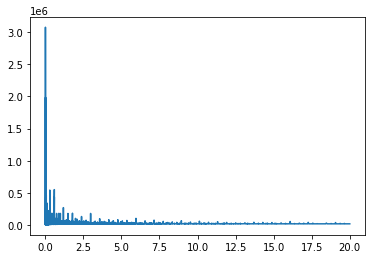

In [65]:
fig,ax = plt.subplots()
ax.plot(res['period'],res['power'])
# ax.set_xlim(-0.5,1)